In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'32g') \
    .config("spark.sql.broadcastTimeout", "1000") \
    .config("spark.driver.maxResultSize", '20g') \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics

%matplotlib inline

In [3]:
#Define preprocessing pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

# load pre-processed table

In [4]:
clean_df = spark.read.load("/project/ds5559/BioNerds/saved_data/clean_indexed.parquet")

In [5]:
clean_df.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+
|file:/project/ds5...|[0.69691277, 0.0,...|ISIC_0032827|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|[0.69691276550292...|       2.0|        1.0|        1.0|         2.0|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0032994|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|[0.0,0.0,0.0,0.0,...|       0.0|        1.0|        5.0|         0.0|
|file:/project/ds5...|[0.0, 0.0, 0.

# load PCA model

In [6]:
pca_path = "/project/ds5559/BioNerds/PCA/pcaModel_50"

In [7]:
%%time
from pyspark.ml.feature import PCAModel
pcaModel_50 = PCAModel.load(pca_path)

CPU times: user 2.29 ms, sys: 3.3 ms, total: 5.59 ms
Wall time: 1.76 s


In [8]:
%%time 
pca_table = pcaModel_50.transform(clean_df)

CPU times: user 3.4 ms, sys: 468 µs, total: 3.87 ms
Wall time: 171 ms


In [9]:
pca_table.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|         pcaFeatures|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+--------------------+
|file:/project/ds5...|[0.69691277, 0.0,...|ISIC_0032827|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|[0.69691276550292...|       2.0|        1.0|        1.0|         2.0|[71.8275654736491...|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0032994|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|[0.0,0.0,0.0,0.0,...|

# assemble features. 

In [10]:
from pyspark.ml.feature import OneHotEncoder


#Define preprocessing pipeline

#OneHot encode variables
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])

#Assemble Features vector
vec_assemb = VectorAssembler(inputCols = ['age', 'OH_sex', 'OH_loc', 'pcaFeatures'], \
                             outputCol = 'Feature_vec', handleInvalid = 'skip')

rf = RandomForestClassifier(labelCol="indexed_dx", featuresCol="Feature_vec", numTrees=100, featureSubsetStrategy ='sqrt', probabilityCol = 'probability')



In [11]:
%%time

model_pipe = Pipeline(stages = [ OH, vec_assemb, rf])

CPU times: user 161 µs, sys: 115 µs, total: 276 µs
Wall time: 196 µs


# split transformed_table to training set and test set by dx. 
# using stratified split by ratio 0.8:0.2

In [12]:
pca_table.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [13]:
fractions = pca_table.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
fractions

{'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [14]:
training_set = pca_table.stat.sampleBy("dx",fractions, seed=314)

In [15]:
%%time
training_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()
training_set.cache()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  411|
|  mel|       1.0|  890|
|   nv|       0.0| 5336|
|  bkl|       2.0|  865|
|   df|       6.0|   95|
| vasc|       5.0|  111|
|akiec|       4.0|  272|
+-----+----------+-----+

CPU times: user 3.35 ms, sys: 1.94 ms, total: 5.29 ms
Wall time: 904 ms


DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

In [16]:
%%time
test_set = pca_table.subtract(training_set)
test_set.cache()

CPU times: user 2.16 ms, sys: 376 µs, total: 2.53 ms
Wall time: 207 ms


DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

In [17]:
%%time
test_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  103|
|  mel|       1.0|  221|
|   nv|       0.0| 1314|
|  bkl|       2.0|  224|
|   df|       6.0|   20|
| vasc|       5.0|   31|
|akiec|       4.0|   55|
+-----+----------+-----+

CPU times: user 18.2 ms, sys: 11.2 ms, total: 29.4 ms
Wall time: 2min 47s


In [18]:
test_set.cache()

DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

# Fit RandomForest Model

### Model with age, sex, localization, age and PCA50

In [19]:
%%time

model_rf = model_pipe.fit(training_set)

CPU times: user 20 ms, sys: 12.7 ms, total: 32.7 ms
Wall time: 1min 39s


In [20]:
%%time
predictions =model_rf.transform(test_set)

CPU times: user 8.25 ms, sys: 1.13 ms, total: 9.38 ms
Wall time: 74.7 ms


In [21]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)

CPU times: user 2.67 ms, sys: 1.51 ms, total: 4.18 ms
Wall time: 1.83 s


0.5714652138801367

In [22]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = predictions.select("prediction","indexed_dx")

In [23]:
metrics = MulticlassMetrics(predictionAndLabels.rdd)
metrics.confusionMatrix().toArray()

array([[1312.,    0.,    2.,    0.,    0.,    0.,    0.],
       [ 211.,    0.,   10.,    0.,    0.,    0.,    0.],
       [ 190.,    0.,   34.,    0.,    0.,    0.,    0.],
       [  92.,    0.,   11.,    0.,    0.,    0.,    0.],
       [  46.,    0.,    9.,    0.,    0.,    0.,    0.],
       [  31.,    0.,    0.,    0.,    0.,    0.,    0.],
       [  20.,    0.,    0.,    0.,    0.,    0.,    0.]])

### confusion matrix

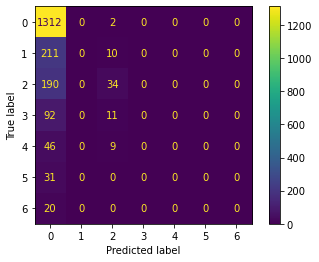

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

#### accuracy, precision, recall, fMeasure

In [25]:
print("accuracy: {}".format(metrics.accuracy))
print("precision: {}".format(metrics.weightedPrecision))
print("recall: {}".format(metrics.weightedRecall))
print("fMeasure: {}".format(metrics.weightedFMeasure()))

accuracy: 0.6839430894308943
precision: 0.5192029551497122
recall: 0.6839430894308943
fMeasure: 0.5714652138801367


### Statistics by class

In [26]:
labels = predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
df = pd.DataFrame()
for label in sorted(labels):
    df = df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
df

,class,f1,precision,recall
0,0.0,0.815920,0.689800,0.998478
1,1.0,0.000000,0.000000,0.000000
2,2.0,0.234483,0.515152,0.151786
3,3.0,0.000000,0.000000,0.000000
4,4.0,0.000000,0.000000,0.000000
5,5.0,0.000000,0.000000,0.000000
6,6.0,0.000000,0.000000,0.000000


# Cross validation

In [19]:
### cross valication
paramGrid = (ParamGridBuilder() \
            .addGrid(rf.numTrees, [10, 50, 100]) \
            .addGrid(rf.maxDepth, [5, 10, 15]) \
            .build())

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")

In [21]:
%%time
# Create 5-fold CrossValidator
cv_model = CrossValidator(estimator=model_pipe, \
                    estimatorParamMaps= paramGrid, \
                    evaluator= evaluator, \
                    numFolds= 5, \
                    parallelism = 4, \
                    seed = 314)

CPU times: user 384 µs, sys: 0 ns, total: 384 µs
Wall time: 388 µs


In [22]:
%%time
cvModel = cv_model.fit(training_set)

CPU times: user 2.87 s, sys: 556 ms, total: 3.42 s
Wall time: 16min 59s


In [23]:
cv_predictions = cvModel.bestModel.transform(test_set)

In [24]:
%%time
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(cv_predictions)

CPU times: user 7.86 ms, sys: 2.63 ms, total: 10.5 ms
Wall time: 9.65 s


0.6939115870882323

In [49]:
bestModel = cvModel.bestModel
print ('Best Param (NumTrees): ', bestModel.stages[2]._java_obj.getNumTrees())
print ('Best Param (MaxDepth): ', bestModel.stages[2].getMaxDepth())

Best Param (NumTrees):  50
Best Param (MaxDepth):  15


In [23]:
cv_predictionAndLabels = cv_predictions.select("prediction","indexed_dx")
preds_and_probs = cv_predictions.select(['indexed_dx', 'probability', 'prediction'])

cv_metrics = MulticlassMetrics(cv_predictionAndLabels.rdd)
cv_metrics.confusionMatrix().toArray()

array([[1.288e+03, 1.000e+01, 1.400e+01, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.550e+02, 4.100e+01, 2.400e+01, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.170e+02, 2.100e+01, 8.000e+01, 1.000e+00, 5.000e+00, 0.000e+00,
        0.000e+00],
       [4.100e+01, 7.000e+00, 2.400e+01, 2.900e+01, 2.000e+00, 0.000e+00,
        0.000e+00],
       [1.800e+01, 3.000e+00, 2.300e+01, 4.000e+00, 7.000e+00, 0.000e+00,
        0.000e+00],
       [2.900e+01, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.500e+01, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]])

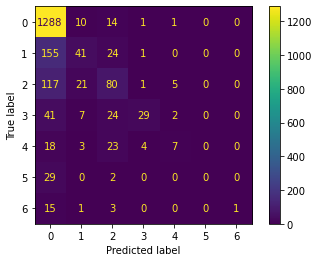

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
ConfusionMatrixDisplay(cv_metrics.confusionMatrix().toArray().astype(int)).plot()

### accuracy

In [25]:
print("accuracy: {}".format(cv_metrics.accuracy))
print("precision: {}".format(cv_metrics.weightedPrecision))
print("recall: {}".format(cv_metrics.weightedRecall))
print("fMeasure: {}".format(cv_metrics.weightedFMeasure()))

accuracy: 0.7347560975609756
precision: 0.6915231017238537
recall: 0.7347560975609756
fMeasure: 0.6826547392839335


### Statistics by class

In [26]:
labels = cv_predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":cv_metrics.precision(label),
               "recall":cv_metrics.recall(label),
               "f1":cv_metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.865301,0.774504,0.980213
1,1.0,0.269737,0.493976,0.185520
2,2.0,0.406091,0.470588,0.357143
3,3.0,0.417266,0.805556,0.281553
4,4.0,0.200000,0.466667,0.127273
5,5.0,0.000000,0.000000,0.000000
6,6.0,0.095238,1.000000,0.050000


### ROC

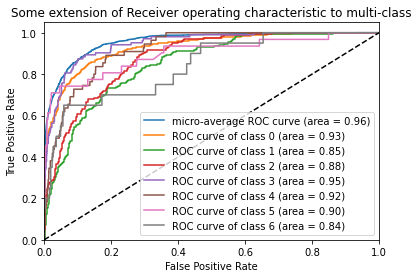

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


y_test = list(preds_and_probs.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(preds_and_probs.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# RandonForest, newly trained TL model, 

### load saved file (image transfered by the new TL model)

In [28]:
RN50_df = spark.read.load("/project/ds5559/BioNerds/saved_data/ResNet50_indexed.parquet")

In [29]:
RN50_df.show(5)
RN50_df.cache()

+-----------+------------+---+---------+----+----+---------------+----------+-----------+-----------+------------+--------------------+------------+--------------------+
|  lesion_id|    image_id| dx|  dx_type| age| sex|   localization|indexed_dx|indexed_sex|indexed_loc|indexed_type|            features|          ID|          features_2|
+-----------+------------+---+---------+----+----+---------------+----------+-----------+-----------+------------+--------------------+------------+--------------------+
|HAM_0004826|ISIC_0027564| nv|follow_up|45.0|male|        genital|       0.0|        0.0|       13.0|         1.0|[2.3282132, 0.0, ...|ISIC_0027564|[2.32821321487426...|
|HAM_0004912|ISIC_0025753|bkl| confocal|70.0|male|           face|       2.0|        0.0|        5.0|         3.0|[0.0, 0.0, 0.0098...|ISIC_0025753|[0.0,0.0,0.009827...|
|HAM_0003060|ISIC_0027485| nv|follow_up|40.0|male|        abdomen|       0.0|        0.0|        4.0|         1.0|[0.021158136, 0.0...|ISIC_0027485|[0

DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string, features_2: vector]

In [30]:
len(RN50_df.select('features_2').first()[0])

2048

### split transformed_table to training set and test set by dx.
### using stratified split by ratio 0.8:0.2

In [31]:
RN50_df.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [32]:
fractions = RN50_df.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
fractions

{'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [33]:
training_RN50 = RN50_df.stat.sampleBy("dx",fractions, seed=314)

In [34]:
%%time
training_RN50.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()
training_RN50.cache()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  399|
|  mel|       1.0|  888|
|   nv|       0.0| 5333|
|  bkl|       2.0|  874|
|   df|       6.0|   89|
| vasc|       5.0|  114|
|akiec|       4.0|  257|
+-----+----------+-----+

CPU times: user 3.75 ms, sys: 1.41 ms, total: 5.16 ms
Wall time: 518 ms


DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string, features_2: vector]

In [35]:
%%time
test_RN50 = RN50_df.subtract(training_RN50)
test_RN50.cache()

CPU times: user 656 µs, sys: 1.89 ms, total: 2.54 ms
Wall time: 72 ms


DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string, features_2: vector]

In [36]:
%%time
test_RN50.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  115|
|  mel|       1.0|  223|
|   nv|       0.0| 1317|
|  bkl|       2.0|  215|
|   df|       6.0|   26|
| vasc|       5.0|   28|
|akiec|       4.0|   70|
+-----+----------+-----+

CPU times: user 4.07 ms, sys: 1.07 ms, total: 5.14 ms
Wall time: 6.36 s


### Traing the RF

In [60]:
#Define preprocessing pipeline

#OneHot encode variables
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])

#Assemble Features vector
vec_assemb = VectorAssembler(inputCols = ['age', 'OH_sex', 'OH_loc', 'features_2'], \
                             outputCol = 'Feature_vec', handleInvalid = 'skip')

rf = RandomForestClassifier(labelCol="indexed_dx", featuresCol="Feature_vec", numTrees=100, featureSubsetStrategy ='sqrt', probabilityCol = 'probability')



In [61]:
%%time
modelTL_pipe = Pipeline(stages = [ OH, vec_assemb, rf])

CPU times: user 249 µs, sys: 87 µs, total: 336 µs
Wall time: 269 µs


In [63]:
%%time
model_rf = modelTL_pipe.fit(training_RN50)

CPU times: user 23.4 ms, sys: 2.95 ms, total: 26.3 ms
Wall time: 11.8 s


In [64]:
%%time
predictions =model_rf.transform(test_RN50)

CPU times: user 8.45 ms, sys: 2.8 ms, total: 11.3 ms
Wall time: 122 ms


In [65]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)

CPU times: user 4.36 ms, sys: 495 µs, total: 4.85 ms
Wall time: 1.09 s


0.6813146390083817

In [66]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = predictions.select("prediction","indexed_dx")

In [67]:
metrics = MulticlassMetrics(predictionAndLabels.rdd)
metrics.confusionMatrix().toArray()

array([[1291.,    9.,   17.,    0.,    0.,    0.,    0.],
       [ 142.,   64.,   14.,    3.,    0.,    0.,    0.],
       [ 118.,   11.,   86.,    0.,    0.,    0.,    0.],
       [  73.,    9.,   15.,   18.,    0.,    0.,    0.],
       [  30.,    4.,   27.,    9.,    0.,    0.,    0.],
       [  19.,    0.,    0.,    0.,    0.,    9.,    0.],
       [  19.,    0.,    7.,    0.,    0.,    0.,    0.]])

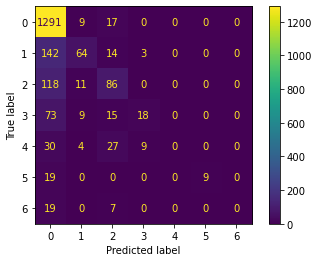

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

In [70]:
print("accuracy: {}".format(metrics.accuracy))
print("precision: {}".format(metrics.weightedPrecision))
print("recall: {}".format(metrics.weightedRecall))
print("fMeasure: {}".format(metrics.weightedFMeasure()))

accuracy: 0.7362086258776329
precision: 0.6822435688377174
recall: 0.7362086258776329
fMeasure: 0.6813146390083817


In [71]:
labels = predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
df = pd.DataFrame()
for label in sorted(labels):
    df = df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
df

,class,f1,precision,recall
0,0.0,0.858092,0.763002,0.980258
1,1.0,0.400000,0.659794,0.286996
2,2.0,0.451444,0.518072,0.400000
3,3.0,0.248276,0.600000,0.156522
4,4.0,0.000000,0.000000,0.000000
5,5.0,0.486486,1.000000,0.321429
6,6.0,0.000000,0.000000,0.000000


### Cross Validation (5 fold) and Tuning hyperparameters

In [72]:
%%time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation

paramGrid = (ParamGridBuilder() \
            .addGrid(rf.numTrees, [10, 50, 100]) \
            .addGrid(rf.maxDepth, [5, 10, 15]) \
            .build())

CPU times: user 218 µs, sys: 0 ns, total: 218 µs
Wall time: 222 µs


In [74]:
%%time
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=modelTL_pipe, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5, \
                    parallelism = 4, \
                    seed = 314 )

CPU times: user 179 µs, sys: 60 µs, total: 239 µs
Wall time: 243 µs


In [75]:
%%time
cvModel = cv.fit(training_RN50)


CPU times: user 3.12 s, sys: 707 ms, total: 3.83 s
Wall time: 13min 57s


In [76]:
%%time
cv_predictions = cvModel.transform(test_RN50)

CPU times: user 3.75 ms, sys: 6.58 ms, total: 10.3 ms
Wall time: 98.3 ms


In [77]:
%%time
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(cv_predictions)

CPU times: user 15.7 ms, sys: 4.84 ms, total: 20.6 ms
Wall time: 11.1 s


0.7543329493557501

In [78]:
bestModel = cvModel.bestModel
print ('Best Param (numTrees): ', bestModel.stages[2]._java_obj.getNumTrees())
print ('Best Param (maxDepth): ', bestModel.stages[2]._java_obj.getMaxDepth())

Best Param (numTrees):  100
Best Param (maxDepth):  15


In [43]:
cv_predictionAndLabels = cv_predictions.select("prediction","indexed_dx")
preds_and_probs = cv_predictions.select(['indexed_dx', 'probability', 'prediction'])

cv_metrics = MulticlassMetrics(cv_predictionAndLabels.rdd)
cv_metrics.confusionMatrix().toArray()

array([[1.266e+03, 2.400e+01, 2.500e+01, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.010e+02, 1.010e+02, 1.800e+01, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00],
       [7.800e+01, 1.700e+01, 1.130e+02, 2.000e+00, 5.000e+00, 0.000e+00,
        0.000e+00],
       [3.700e+01, 7.000e+00, 1.800e+01, 5.000e+01, 2.000e+00, 1.000e+00,
        0.000e+00],
       [1.700e+01, 6.000e+00, 2.500e+01, 1.100e+01, 1.100e+01, 0.000e+00,
        0.000e+00],
       [1.200e+01, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.400e+01,
        0.000e+00],
       [1.800e+01, 1.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]])

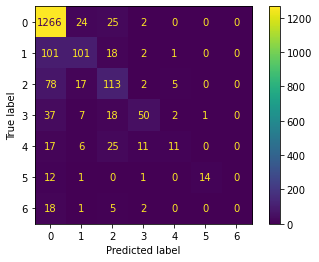

In [44]:
ConfusionMatrixDisplay(cv_metrics.confusionMatrix().toArray().astype(int)).plot()

In [45]:
print("accuracy: {}".format(cv_metrics.accuracy))
print("precision: {}".format(cv_metrics.weightedPrecision))
print("recall: {}".format(cv_metrics.weightedRecall))
print("fMeasure: {}".format(cv_metrics.weightedFMeasure()))

accuracy: 0.779839518555667
precision: 0.7531694614238973
recall: 0.7798395185556672
fMeasure: 0.7542135376151725


In [46]:
labels = cv_predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":cv_metrics.precision(label),
               "recall":cv_metrics.recall(label),
               "f1":cv_metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.889670,0.827992,0.961276
1,1.0,0.531579,0.643312,0.452915
2,2.0,0.539379,0.553922,0.525581
3,3.0,0.540541,0.714286,0.434783
4,4.0,0.247191,0.578947,0.157143
5,5.0,0.651163,0.933333,0.500000
6,6.0,0.000000,0.000000,0.000000


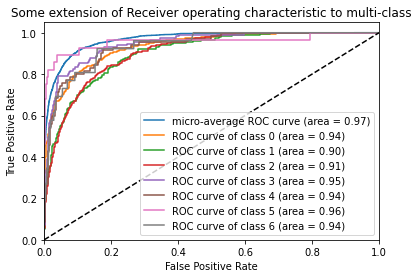

In [47]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test = list(preds_and_probs.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(preds_and_probs.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])
n_classes = y_test.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()